In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from env import get_connection
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats

# ACQUIRE

In [2]:
# create helper function to get the necessary connection url.
def get_db_connection(database):
    return get_connection(database)

# connect to sql zillow database
url = "zillow"

# use this query to get data    
sql_query = '''SELECT *
            FROM predictions_2017
            JOIN properties_2017 on properties_2017.parcelid = predictions_2017.parcelid
            JOIN propertylandusetype on propertylandusetype.propertylandusetypeid = properties_2017.propertylandusetypeid;
            '''

# assign data to data frame
df = pd.read_sql(sql_query, get_connection(url))

In [3]:
#filter out single family residential as requested
df= df[df['propertylandusedesc'] == 'Single Family Residential']
df.shape

(52442, 65)

# PREPARE

In [4]:
# Convert the 'transactiondate' column to datetime
df['transactiondate'] = pd.to_datetime(df['transactiondate'])

# Define the start and end dates for the range
start_date = pd.to_datetime('2017-01-01')
end_date = pd.to_datetime('2017-12-31')

# Filter the DataFrame to keep rows within the specified date range
df= df[(df['transactiondate'] >= start_date) & (df['transactiondate'] <= end_date)]


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 77578
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   id                            52441 non-null  int64         
 1   parcelid                      52441 non-null  int64         
 2   logerror                      52441 non-null  float64       
 3   transactiondate               52441 non-null  datetime64[ns]
 4   id                            52441 non-null  int64         
 5   parcelid                      52441 non-null  int64         
 6   airconditioningtypeid         13638 non-null  float64       
 7   architecturalstyletypeid      70 non-null     float64       
 8   basementsqft                  47 non-null     float64       
 9   bathroomcnt                   52441 non-null  float64       
 10  bedroomcnt                    52441 non-null  float64       
 11  buildingclasstypeid         

In [6]:
#deciding which columns to keep 
columns_to_keep = ['bathroomcnt',
                   'bedroomcnt',
                   'calculatedfinishedsquarefeet',
                   'regionidzip',
                   'yearbuilt',
                   'fullbathcnt',
                   'taxvaluedollarcnt']
df = df[columns_to_keep]

In [7]:
#dropping more nulls
df.dropna()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,regionidzip,yearbuilt,fullbathcnt,taxvaluedollarcnt
0,3.5,4.0,3100.0,96978.0,1998.0,3.0,1023282.0
1,1.0,2.0,1465.0,97099.0,1967.0,1.0,464000.0
2,2.0,3.0,1243.0,97078.0,1962.0,2.0,564778.0
3,3.0,4.0,2376.0,96330.0,1970.0,3.0,145143.0
6,3.0,4.0,2962.0,96293.0,1950.0,3.0,773303.0
...,...,...,...,...,...,...,...
77573,2.0,4.0,1633.0,96204.0,1962.0,2.0,346534.0
77575,2.0,2.0,1286.0,96284.0,1940.0,2.0,354621.0
77576,2.0,4.0,1612.0,97116.0,1964.0,2.0,67205.0
77577,1.0,3.0,1032.0,96480.0,1954.0,1.0,49546.0


In [8]:
#1. Rename the columns to be more readable
df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                          'bathroomcnt':'bathrooms', 
                          'calculatedfinishedsquarefeet':'area', 
                          'taxvaluedollarcnt':'tax_value', 
                          'regionidzip':'zip'})

In [9]:
df.isna().sum()

bathrooms        0
bedrooms         0
area            82
zip             26
yearbuilt      116
fullbathcnt    137
tax_value        1
dtype: int64

In [10]:
df=df.dropna()

In [11]:
df.isna().sum()

bathrooms      0
bedrooms       0
area           0
zip            0
yearbuilt      0
fullbathcnt    0
tax_value      0
dtype: int64

In [12]:
df = df.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52244 entries, 0 to 77578
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   bathrooms    52244 non-null  int64
 1   bedrooms     52244 non-null  int64
 2   area         52244 non-null  int64
 3   zip          52244 non-null  int64
 4   yearbuilt    52244 non-null  int64
 5   fullbathcnt  52244 non-null  int64
 6   tax_value    52244 non-null  int64
dtypes: int64(7)
memory usage: 3.2 MB


In [13]:
df.shape

(52244, 7)

For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an MVP (minimally viable product).

In [14]:
X = df[['area', 'bedrooms', 'bathrooms']]
y = df['tax_value']

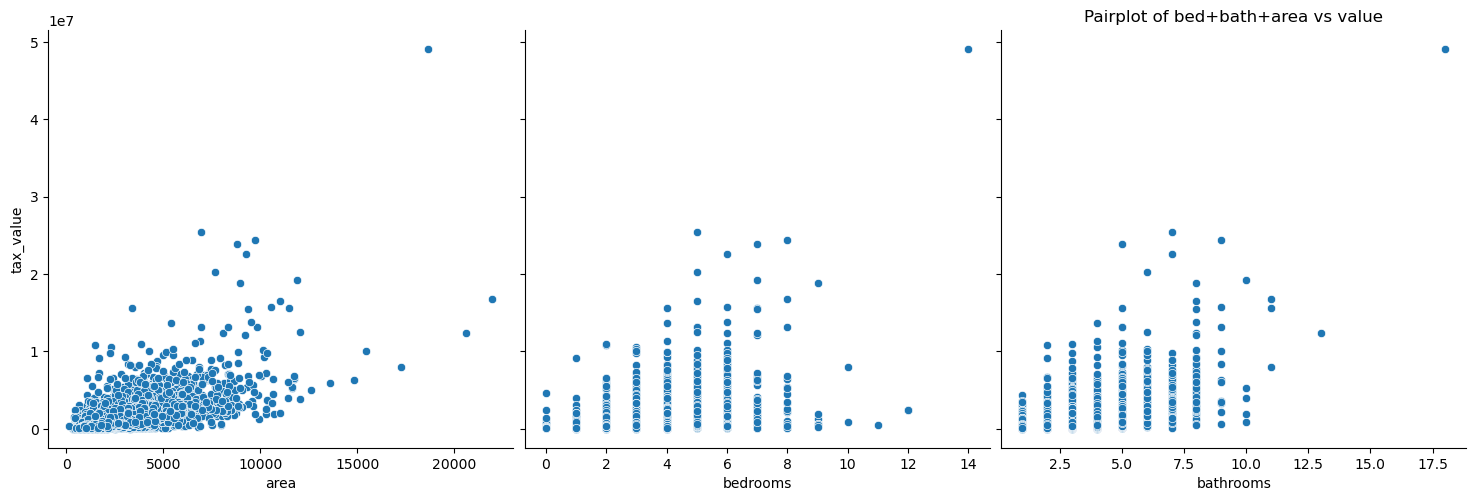

In [15]:
# Create a pairplot
sns.pairplot(df, x_vars=['area', 'bedrooms', 'bathrooms'], y_vars=['tax_value'], kind='scatter', size=5)

# Set plot labels and title
plt.xlabel("bathrooms")
plt.ylabel("Y Variable")
plt.title("Pairplot of bed+bath+area vs value")
plt.show()

### Take Aways:

1) There seem to be more transaction at the middle of the data 

2) The trend is to have a higher number of bedrooms and unequivalently low number of bathrooms

3) transaction mostly range at around 0 to 8000 area

### Hypothesis 1

1) The higher the area, the higher the tax value
    
    Null: The area are independent of the tax value
    
    Alternative: The area has a relationship with the tax value

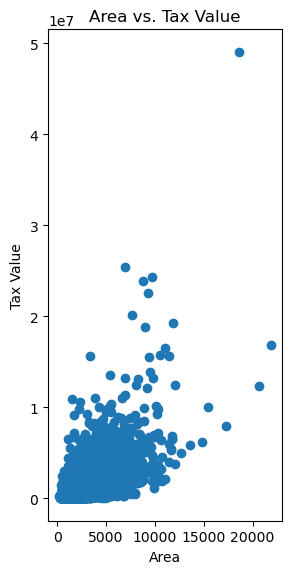

In [16]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(8, 6))

# Scatter plot for 'area' vs. 'tax_value'
plt.subplot(131)
plt.scatter(df['area'], df['tax_value'])
plt.title('Area vs. Tax Value')
plt.xlabel('Area')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

### Hypothesis 2

2) The more the bedrooms the higher the tax value
    Null: The bedrooms are independent of the tax value
    Alternative: The bedrooms has a relationship with the tax value

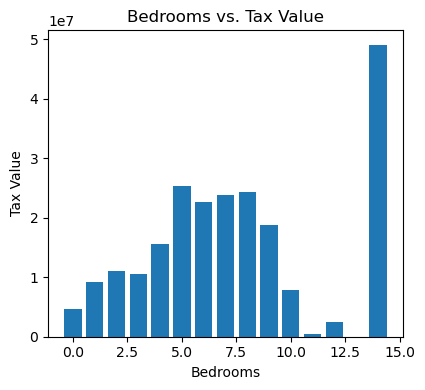

In [17]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bedrooms' vs. 'tax_value'
plt.subplot(132)
plt.bar(df['bedrooms'], df['tax_value'])
plt.title('Bedrooms vs. Tax Value')
plt.xlabel('Bedrooms')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

### Hypothesis 3

3) the more the bathrooms the higher the tax value
    Null: The bathrooms are independent of the tax value
    Alternative: The bedrooms has a relationship with the tax value

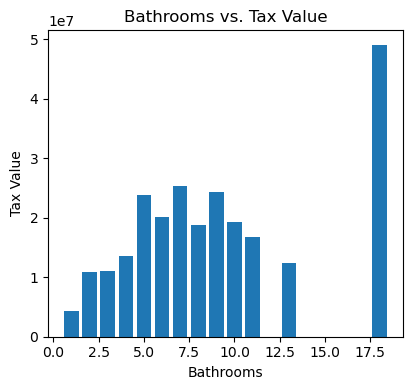

In [18]:
# Create scatter plots for each feature against 'tax_value'
plt.figure(figsize=(12, 4))

# Scatter plot for 'bathrooms' vs. 'tax_value'
plt.subplot(133)
plt.bar(df['bathrooms'], df['tax_value'])
plt.title('Bathrooms vs. Tax Value')
plt.xlabel('Bathrooms')
plt.ylabel('Tax Value')

plt.tight_layout()
plt.show()

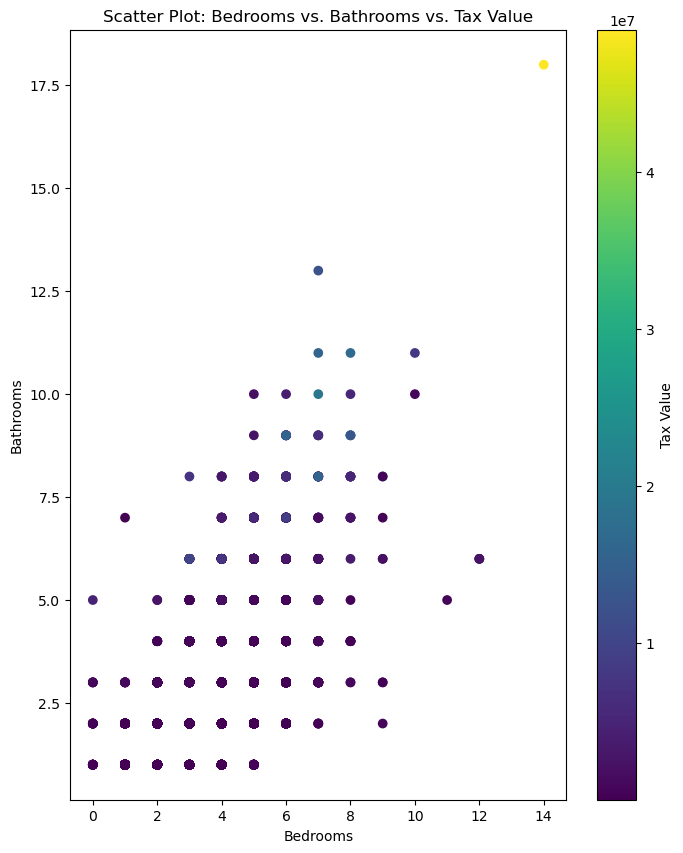

In [19]:
# Create a scatter plot
plt.figure(figsize=(8, 10))
plt.scatter(df['bedrooms'], df['bathrooms'], c=df['tax_value'], cmap='viridis', marker='o')
plt.colorbar(label='Tax Value')
plt.title('Scatter Plot: Bedrooms vs. Bathrooms vs. Tax Value')
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')
plt.show()

As expected high numbers of bedrooms and bathroom does tend to have a high tax value

# MVP

start with splitting data, then scale the data, fit the train into regression model

In [45]:
# Split the data into features (X) and target (y)
X = df.drop(columns=['tax_value'])  # Features (all columns except 'tax_value')
y = df['tax_value']                # Target variable ('tax_value')

# Split the data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_validate shape:", X_validate.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_validate shape:", y_validate.shape)
print("y_test shape:", y_test.shape)

X_train shape: (36570, 6)
X_validate shape: (7837, 6)
X_test shape: (7837, 6)
y_train shape: (36570,)
y_validate shape: (7837,)
y_test shape: (7837,)


In [28]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

# Note: Only transform (not fit) the validation and test data to avoid data leakage

In [37]:
X_train.shape, y_train.shape

((36570, 6), (36570,))

In [39]:
X_train.head()

,bathrooms,bedrooms,area,zip,yearbuilt,fullbathcnt
19315,2,3,1854,97106,1971,2
26130,3,4,3506,97118,1990,3
38332,2,3,1600,96469,1962,2
58115,1,2,810,96193,1949,1
34374,2,3,1134,97319,1997,2


# fit linear regression model

In [40]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [41]:
y_train['yhat_lm'] = lm.predict(X_train)

In [43]:
y_train.head()

19315     70605
26130    785372
38332     73075
58115    354296
34374    157100
Name: tax_value, dtype: object